In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy import linalg as la
from scipy.optimize import minimize

In [2]:
from scipy.special import erf,erfc

### Define Constants and Functions

In [4]:
def U(T, To, r, mu, Tbar, s_min=0, s_max=1, scen="CST", Ts=None, Pb=None):
    """
    Analytical formula for the potential in the case of CST or of 1 TCL in CPO.
    """

    si = s_min + int(T > Tbar) * (s_max-s_min)

    if scen == "CST":
        U = (T-To)**2/(2*r) + cp*mu*si/2*((T-Ts)**2 - (Tbar-Ts)**2)
    elif scen == "CPO":
        Ts = To - Pb/(mu*si)
        U = (T-To)**2/(2*r) + cp*mu*si/2 * \
            ((T - Ts)**2-(Tbar - Ts)**2)

    return U


def Z(alpha, To, r, mu, Tbar, s_min=0, s_max=1, scen="CST", Ts=None, Pb=None):
    """
    Partition function for the marginal distribution.
    """

    # first part of the integral, for T < Tbar
    beta, delta, gamma = get_coeffs(
        To, r, mu, Tbar, s_min, alpha, scen=scen, Ts=Ts, Pb=Pb)

    Z1 = np.exp(gamma)/np.sqrt(beta)*np.sqrt(np.pi) / \
        2*(erf(np.sqrt(beta)*(Tbar-delta))+1)

    # second part of the integral, for T > Tbar
    beta, delta, gamma = get_coeffs(
        To, r, mu, Tbar, s_max, alpha, scen=scen, Ts=Ts, Pb=Pb)

    Z2 = np.exp(gamma)/np.sqrt(beta)*np.sqrt(np.pi) / \
        2*erfc(np.sqrt(beta)*(Tbar-delta))

    return Z1+Z2


def get_coeffs(To, r, mu,  Tbar, s, alpha, scen="CST", Ts=None, Pb=None):
    """
    Computes coefficients enabling analytical derivation of the pdf.
    Notes
    -----
    - The potential is rewritten as U = aT**2 - bT - c
    - The pdf has therefore the form
                    P \propto exp(-alpha * (aT**2 - bT - c))
                    P \propto exp(- beta * (T-delta)**2 + gamma)
    - beta, delta, gamma enable the expression of Z as a function of erf, erfc 
    functions
    """

    if scen == "CST":
        a = (1/(2*r) + cp*mu*s/2)
        b = To/r + 2*Ts*cp*mu*s/2
        c = -(To**2/(2*r) + cp*mu*s/2*(2*Tbar*Ts - Tbar**2))

    elif scen == "CPO":
        eta = mu*s*cp/2
        eps = To - Pb/(mu*s)
        dzeta = Tbar - eps
        a = 1/(2*r) + eta
        b = To/r + 2*eps*eta
        c = -(To**2/(2*r)+eta*eps**2-eta*dzeta**2)

    beta = alpha*a
    delta = b/(2*a)
    gamma = alpha*(c+b**2/(4*a))

    return beta, delta, gamma


def get_P(alpha, T, To, r, mu, Tbar, s_min=0, s_max=1, scen="CST", Ts=None, Pb=None):
    """
    Compute the probability distribution.
    """

    U_ = U(T, To, r, mu,  Tbar, s_min=s_min, s_max=s_max, scen=scen, Ts=Ts, Pb=Pb)
    Z_ = Z(alpha, To, r, mu, Tbar, s_min=s_min,
           s_max=s_max, scen=scen, Ts=Ts, Pb=Pb)

    return np.exp(-alpha*U_)/Z_

In [60]:
s_minus = 0
s_plus = 1
alpha = 1
N = 1
Tc = 24
beta = 1
To = 30
Ts = 20
muBar = 0.5
cp = 1
r = 2
c = 15
D = 10

In [61]:
def f_Tbar(Tbar):
    s = lambda T: s_minus if T <= Tbar else s_plus
    Lcomf = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts) * (T-Tc)**2
    Lpower = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts)*s(T)
    val = alpha*N/2 * quad(Lcomf,-np.inf,np.inf)[0] + beta*(To-Ts)*muBar*N*quad(Lpower,-np.inf,np.inf)[0]
    return val
f_Tbar = np.vectorize(f_Tbar,otypes=[np.ndarray])

### Minimize Tbar

In [62]:
tbarDom = np.linspace(10,40,101)
fVal = f_Tbar(tbarDom)

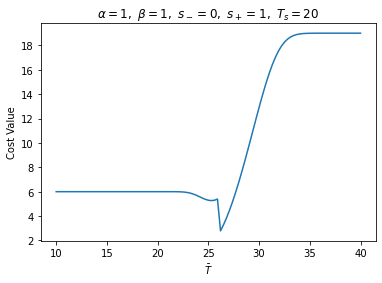

In [63]:
plt.plot(tbarDom,fVal)
plt.xlabel(r"$\bar{T}$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ s_-={s_minus},\ s_+={s_plus},\ T_s={Ts}$")
# plt.savefig("tbar_1a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [59]:
minimize(f_Tbar,26.5,method='Nelder-Mead')

 final_simplex: (array([[29.99996033],
       [30.0000412 ]]), array([47.48794716, 47.48794716]))
           fun: 47.48794715775803
       message: 'Optimization terminated successfully.'
          nfev: 34
           nit: 17
        status: 0
       success: True
             x: array([29.99996033])

In [37]:
alpha = 0.5
beta = 0.5

In [10]:
tbarDom = np.linspace(10,40,101)
fVal = f_Tbar(tbarDom)

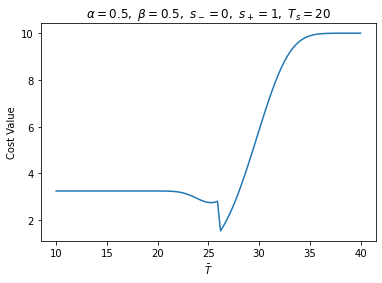

In [11]:
plt.plot(tbarDom,fVal)
plt.xlabel(r"$\bar{T}$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ s_-={s_minus},\ s_+={s_plus},\ T_s={Ts}$")
plt.savefig("tbar_2a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [12]:
minimize(f_Tbar,26.5,method='Nelder-Mead')

 final_simplex: (array([[25.92904663],
       [25.9291275 ]]), array([1.37821581, 1.37826228]))
           fun: 1.3782158128862048
       message: 'Optimization terminated successfully.'
          nfev: 45
           nit: 22
        status: 0
       success: True
             x: array([25.92904663])

In [13]:
alpha = 1
beta = 0.5

In [14]:
tbarDom = np.linspace(10,40,101)
fVal = f_Tbar(tbarDom)

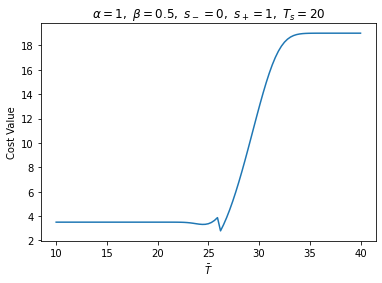

In [15]:
plt.plot(tbarDom,fVal)
plt.xlabel(r"$\bar{T}$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ s_-={s_minus},\ s_+={s_plus},\ T_s={Ts}$")
plt.savefig("tbar_3a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [16]:
minimize(f_Tbar,26.5,method='Nelder-Mead')

 final_simplex: (array([[25.92904663],
       [25.92908707]]), array([2.38818372, 2.38823895]))
           fun: 2.388183716879147
       message: 'Optimization terminated successfully.'
          nfev: 45
           nit: 22
        status: 0
       success: True
             x: array([25.92904663])

In [17]:
alpha = 0.5
beta = 1

In [18]:
tbarDom = np.linspace(10,40,101)
fVal = f_Tbar(tbarDom)

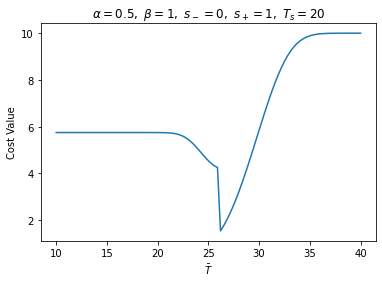

In [19]:
plt.plot(tbarDom,fVal)
plt.xlabel(r"$\bar{T}$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ s_-={s_minus},\ s_+={s_plus},\ T_s={Ts}$")
plt.savefig("tbar_4a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [20]:
minimize(f_Tbar,26.5,method='Nelder-Mead')

 final_simplex: (array([[25.92904663],
       [25.9291275 ]]), array([1.37821581, 1.37826228]))
           fun: 1.378215812886205
       message: 'Optimization terminated successfully.'
          nfev: 44
           nit: 22
        status: 0
       success: True
             x: array([25.92904663])

### Minimize s-

In [21]:
# s_minus = 0.2
s_plus = 1
alpha = 1
N = 1
Tc = 24
beta = 1
To = 30
Ts = 20
Tbar = 25
Tbar = 25.92904663
muBar = 0.5
cp = 1
r = 2
c = 15
D = 10
s = lambda T: s_minus if T <= Tbar else s_plus

In [22]:
def f_s_minus(s_minus):
    s = lambda T: s_minus if T <= Tbar else s_plus
    Lcomf = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts) * (T-Tc)**2
    Lpower = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts)*s(T)
    val = alpha*N/2 * quad(Lcomf,-np.inf,np.inf)[0] + beta*(To-Ts)*muBar*N*quad(Lpower,-np.inf,np.inf)[0]
    return val
f_s_minus = np.vectorize(f_s_minus,otypes=[np.ndarray])

In [23]:
s_minus_DOM = np.linspace(0,1,101)
fVal = f_s_minus(s_minus_DOM)

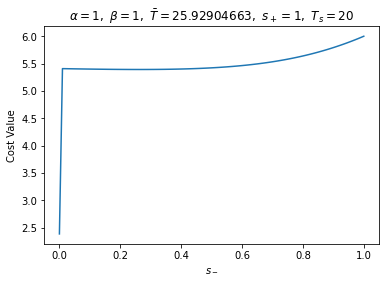

In [24]:
plt.plot(s_minus_DOM,fVal)
plt.xlabel(r"$s_-$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ \bar T={Tbar},\ s_+={s_plus},\ T_s={Ts}$")
plt.savefig("s_minus_1a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [25]:
bnds = ((0,1),)
minimize(f_s_minus,0,bounds=bnds)

      fun: array([2.3881837157052472], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.02100601e+08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
   status: 0
  success: True
        x: array([0.])

In [26]:
alpha = 0.5
beta = 0.5

In [27]:
s_minus_DOM = np.linspace(0,1,101)
fVal = f_s_minus(s_minus_DOM)

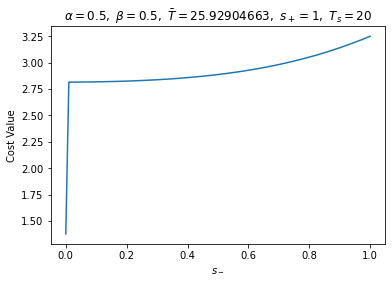

In [28]:
plt.plot(s_minus_DOM,fVal)
plt.xlabel(r"$s_-$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ \bar T={Tbar},\ s_+={s_plus},\ T_s={Ts}$")
plt.savefig("s_minus_2a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [29]:
bnds = ((0,1),)
minimize(f_s_minus,0.5,bounds=bnds)

      fun: array([1.378215812392421], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.43700109e+08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([0.])

In [30]:
alpha = 1
beta = 0.5

In [31]:
s_minus_DOM = np.linspace(0,1,101)
fVal = f_s_minus(s_minus_DOM)

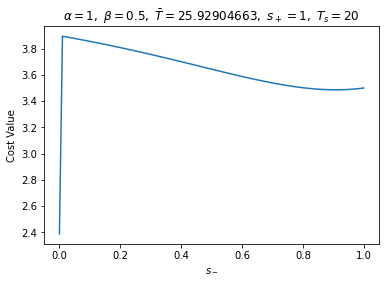

In [32]:
plt.plot(s_minus_DOM,fVal)
plt.xlabel(r"$s_-$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ \bar T={Tbar},\ s_+={s_plus},\ T_s={Ts}$")
plt.savefig("s_minus_3a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [33]:
bnds = ((0,1),)
minimize(f_s_minus,0.5,bounds=bnds)

      fun: array([3.4863691112931035], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.63993297e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 6
   status: 0
  success: True
        x: array([0.90830221])

In [34]:
alpha = 0.5
beta = 1

In [35]:
s_minus_DOM = np.linspace(0,1,101)
fVal = f_s_minus(s_minus_DOM)

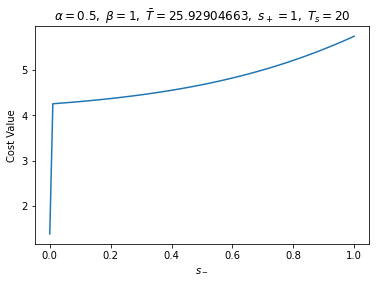

In [36]:
plt.plot(s_minus_DOM,fVal)
plt.xlabel(r"$s_-$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ \bar T={Tbar},\ s_+={s_plus},\ T_s={Ts}$")
plt.savefig("s_minus_4a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [37]:
bnds = ((0,1),)
minimize(f_s_minus,0.5,bounds=bnds)

      fun: array([1.3782158123924213], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.87400218e+08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([0.])

### Minimize s+

In [38]:
s_minus = 0
# s_plus = 1
alpha = 1
N = 1
Tc = 24
beta = 1
To = 30
Ts = 20
Tbar = 25
Tbar = 25.92904663
muBar = 0.5
cp = 1
r = 2
c = 15
D = 10
s = lambda T: s_minus if T <= Tbar else s_plus

In [39]:
def f_s_plus(s_plus):
    s = lambda T: s_minus if T <= Tbar else s_plus
    Lcomf = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts) * (T-Tc)**2
    Lpower = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts)*s(T)
    val = alpha*N/2 * quad(Lcomf,-np.inf,np.inf)[0] + beta*(To-Ts)*muBar*N*quad(Lpower,-np.inf,np.inf)[0]
    return val
f_s_plus = np.vectorize(f_s_plus,otypes=[np.ndarray])

In [40]:
s_plus_DOM = np.linspace(0,1,101)
fVal = f_s_plus(s_plus_DOM)

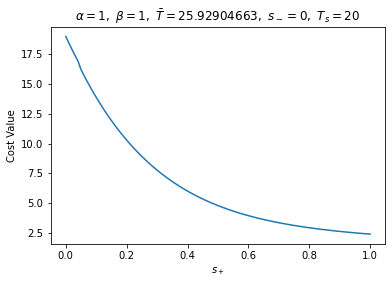

In [41]:
plt.plot(s_plus_DOM,fVal)
plt.xlabel(r"$s_+$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ \bar T={Tbar},\ s_-={s_minus},\ T_s={Ts}$")
plt.savefig("s_plus_1a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [42]:
bnds = ((0,1),)
minimize(f_s_plus,0.5,bounds=bnds)

      fun: array([2.3881837157052472], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.97430672])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([1.])

In [43]:
alpha = 0.5
beta = 0.5

In [44]:
s_plus_DOM = np.linspace(0,1,101)
fVal = f_s_plus(s_plus_DOM)

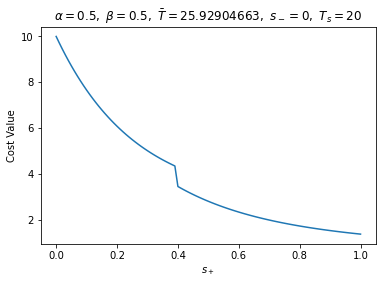

In [45]:
plt.plot(s_plus_DOM,fVal)
plt.xlabel(r"$s_+$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ \bar T={Tbar},\ s_-={s_minus},\ T_s={Ts}$")
plt.savefig("s_plus_2a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [46]:
bnds = ((0,1),)
minimize(f_s_plus,0.5,bounds=bnds)

      fun: array([1.378215812392421], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.36612459])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([1.])

In [47]:
alpha = 1
beta = 0.5

In [48]:
s_plus_DOM = np.linspace(0,1,101)
fVal = f_s_plus(s_plus_DOM)

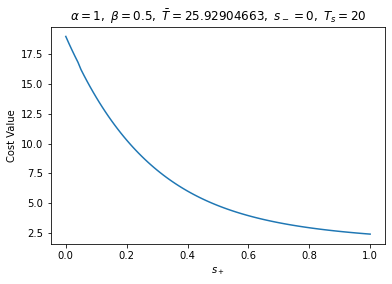

In [49]:
plt.plot(s_plus_DOM,fVal)
plt.xlabel(r"$s_+$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ \bar T={Tbar},\ s_-={s_minus},\ T_s={Ts}$")
plt.savefig("s_plus_3a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [50]:
bnds = ((0,1),)
minimize(f_s_plus,0.5,bounds=bnds)

      fun: array([2.3881837157052472], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.97430672])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([1.])

In [51]:
alpha = 0.5
beta = 1

In [52]:
s_plus_DOM = np.linspace(0,1,101)
fVal = f_s_plus(s_plus_DOM)

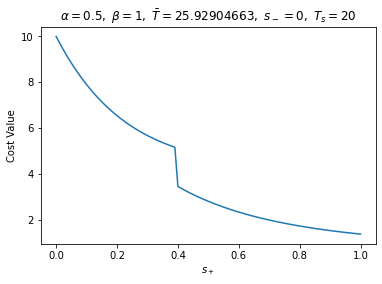

In [53]:
plt.plot(s_plus_DOM,fVal)
plt.xlabel(r"$s_+$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ \bar T={Tbar},\ s_-={s_minus},\ T_s={Ts}$")
plt.savefig("s_plus_4a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [54]:
bnds = ((0,1),)
minimize(f_s_plus,0.5,bounds=bnds)

      fun: array([1.3782158123924213], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.36612459])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([1.])

### Minimize $T_s$

In [130]:
s_minus = 0
s_plus = 1
alpha = 1
N = 1
Tc = 24
beta = 1
To = 30
# Ts = 20
Tbar = 25
Tbar = 25.92904663
muBar = 0.5
cp = 1
r = 2
c = 15
D = 10
s = lambda T: s_minus if T <= Tbar else s_plus

In [131]:
def f_Ts(Ts):
    s = lambda T: s_minus if T <= Tbar else s_plus
    Lcomf = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts) * (T-Tc)**2
    Lpower = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts)*s(T)
    val = alpha*N/2 * quad(Lcomf,-np.inf,np.inf)[0] + beta*(To-Ts)*muBar*N*quad(Lpower,-np.inf,np.inf)[0]
    return val
f_Ts = np.vectorize(f_Ts,otypes=[np.ndarray])

In [132]:
tsDom = np.linspace(10,40,101)
fVal = f_Ts(tsDom)

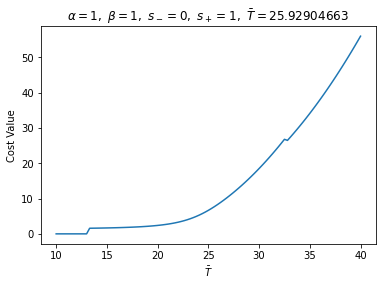

In [133]:
plt.plot(tsDom,fVal)
plt.xlabel(r"$\bar{T}$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ s_-={s_minus},\ s_+={s_plus},\ \bar T={Tbar}$")
plt.savefig("ts_1a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [134]:
bnds = ((10,40),)
minimize(f_Ts,26.5,bounds=bnds)

      fun: array([2.7199675000540107e-10], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.94090727e-10])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 6
   status: 0
  success: True
        x: array([11.62388223])

In [135]:
alpha = 0.5
beta = 0.5

In [136]:
tsDom = np.linspace(10,40,101)
fVal = f_Ts(tsDom)

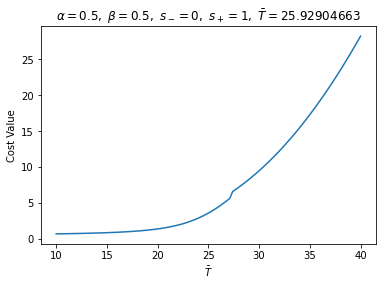

In [137]:
plt.plot(tsDom,fVal)
plt.xlabel(r"$\bar{T}$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ s_-={s_minus},\ s_+={s_plus},\ \bar T={Tbar}$")
plt.savefig("ts_2a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [138]:
bnds = ((10,40),)
minimize(f_Ts,26.5,bounds=bnds)

      fun: array([0.6906012664966333], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.0199448])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 6
   status: 0
  success: True
        x: array([10.])

In [139]:
alpha = 1
beta = 0.5

In [140]:
tsDom = np.linspace(10,40,101)
fVal = f_Ts(tsDom)

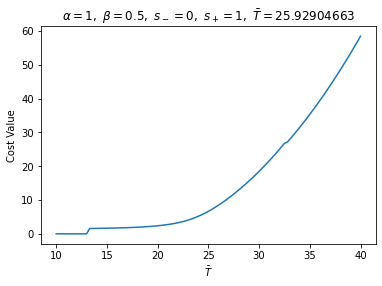

In [141]:
plt.plot(tsDom,fVal)
plt.xlabel(r"$\bar{T}$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ s_-={s_minus},\ s_+={s_plus},\ \bar T={Tbar}$")
plt.savefig("ts_3a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [142]:
bnds = ((10,40),)
minimize(f_Ts,26.5,bounds=bnds)

      fun: array([2.2901531252195211e-10], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.11151853e-10])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 6
   status: 0
  success: True
        x: array([11.6238849])

In [143]:
alpha = 0.5
beta = 1

In [144]:
tsDom = np.linspace(10,40,101)
fVal = f_Ts(tsDom)

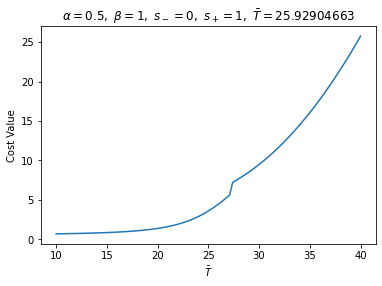

In [145]:
plt.plot(tsDom,fVal)
plt.xlabel(r"$\bar{T}$")
plt.ylabel("Cost Value")
plt.title(fr"$\alpha={alpha},\ \beta={beta},\ s_-={s_minus},\ s_+={s_plus},\ \bar T={Tbar}$")
plt.savefig("ts_4a.jpeg",dpi=640,bbox_inches='tight')
plt.show()

In [146]:
bnds = ((10,40),)
minimize(f_Ts,26.5,bounds=bnds)

      fun: array([0.6906012664966333], dtype=object)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.0199448])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 6
   status: 0
  success: True
        x: array([10.])

### OLD

In [109]:
T = 24

In [73]:
get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts)

0.045078656560785274

In [74]:
def f(Tbar):
    s_minus = 0.2
    s_plus = 1
    alpha = 1
    N = 1
    Tc = 24
    beta = 1
    To = 30
    Ts = 20
    muBar = 0.5
    cp = 1
    r = 2
    c = 15
    D = 10
    s = lambda T: s_minus if T <= Tbar else s_plus
    U1 = lambda T: (T-To)**2/(2*r) + cp*muBar*s(T)/2 * ((T-Ts)**2 - (Tbar-Ts)**2)
    Zfunc = lambda T: np.exp(-c/D * U1(T))
    Z = quad(Zfunc,-np.inf,np.inf)[0]
    P = lambda T: 1/Z * np.exp(-c/D * U1(T))
    Lcomf = lambda T: P(T) * (T-Tc)**2
    Lpower = lambda T: P(T)*s(T)
    val = alpha*N/2 * quad(Lcomf,-np.inf,np.inf)[0] + beta*(To-Ts)*muBar*N*quad(Lpower,-np.inf,np.inf)[0]
    return val
f = np.vectorize(f,otypes=[np.ndarray])

In [75]:
f(0.5)

array(5.833333333333292, dtype=object)

In [76]:
tbarDom = np.linspace(20,30,1001)
fVal = f(tbarDom)

/Users/aaronlarsen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


In [77]:
f(15)

array(68609101.52086288, dtype=object)

In [78]:
fVal

array([8654.384639568514, 8654.384639568329, 8654.38463956781, ...,
       10.468547905091988, 10.475890290618727, 10.48314857787032],
      dtype=object)

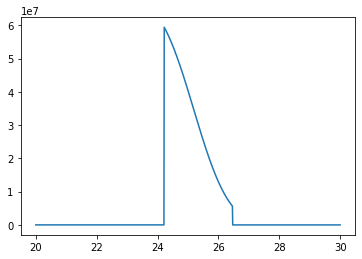

In [79]:
plt.plot(tbarDom,fVal)
plt.show()

In [80]:
def partition(Tbar):
    s_minus = 0.2
    s_plus = 1
    alpha = 1
    N = 1
    Tc = 24
    beta = 1
    To = 30
    Ts = 20
    muBar = 0.5
    cp = 1
    r = 2
    c = 15
    D = 10
    s = lambda T: s_minus if T <= Tbar else s_plus
    U1 = lambda T: (T-To)**2/(2*r) + cp*muBar*s(T)/2 * ((T-Ts)**2 - (Tbar-Ts)**2)
    Zfunc = lambda T: np.exp(-c/D * U1(T))
    Z = quad(Zfunc,-np.inf,np.inf)[0]
    return Z
partition = np.vectorize(partition,otypes=[np.ndarray])

In [81]:
tbarDom = np.linspace(20,30,1001)
zVal = partition(tbarDom)

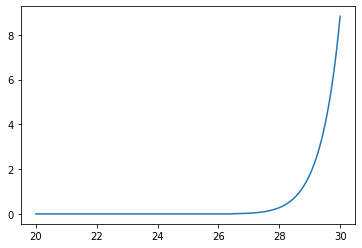

In [82]:
plt.plot(tbarDom,zVal)

In [83]:
def P(Tbar,T):
    s_minus = 0.2
    s_plus = 1
    alpha = 1
    N = 1
    Tc = 24
    beta = 1
    To = 30
    Ts = 20
    muBar = 0.5
    cp = 1
    r = 2
    c = 15
    D = 10
    s = lambda T: s_minus if T <= Tbar else s_plus
    U1 = lambda T: (T-To)**2/(2*r) + cp*muBar*s(T)/2 * ((T-Ts)**2 - (Tbar-Ts)**2)
    Zfunc = lambda T: np.exp(-c/D * U1(T))
    Z = quad(Zfunc,-np.inf,np.inf)[0]
    P = lambda T: 1/Z * np.exp(-c/D * U1(T))
    return P(T)
P = np.vectorize(P,otypes=[np.ndarray])

In [84]:
tbarDom = np.linspace(20,30,1001)
Pval = P(25,np.linspace(-10,10,1001))

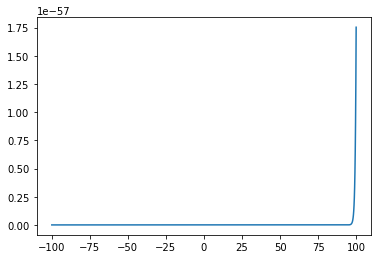

In [85]:
plt.plot(np.linspace(-100,100,1001),Pval)

In [86]:
def Lcomf(Tbar):
    s_minus = 0.2
    s_plus = 1
    alpha = 1
    N = 1
    Tc = 24
    beta = 1
    To = 30
    Ts = 20
    muBar = 0.5
    cp = 1
    r = 2
    c = 15
    D = 10
    s = lambda T: s_minus if T <= Tbar else s_plus
    U1 = lambda T: (T-To)**2/(2*r) + cp*muBar*s(T)/2 * ((T-Ts)**2 - (Tbar-Ts)**2)
    Zfunc = lambda T: np.exp(-c/D * U1(T))
    Z = quad(Zfunc,-np.inf,np.inf)[0]
    P = lambda T: 1/Z * np.exp(-c/D * U1(T))
    Lcomf = lambda T: P(T) * (T-Tc)**2
    val = alpha*N/2 * quad(Lcomf,-np.inf,np.inf)[0]
    return val
Lcomf = np.vectorize(Lcomf,otypes=[np.ndarray])

In [87]:
tbarDom = np.linspace(20,30,1001)
Lcomfval = Lcomf(tbarDom)

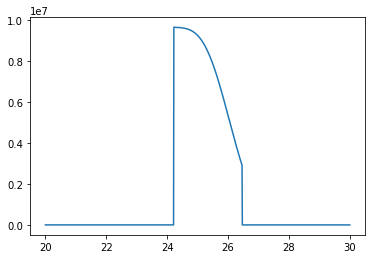

In [88]:
plt.plot(tbarDom,Lcomfval)

In [89]:
def Lpower(Tbar):
    s_minus = 0.2
    s_plus = 1
    alpha = 1
    N = 1
    Tc = 24
    beta = 1
    To = 30
    Ts = 20
    muBar = 0.5
    cp = 1
    r = 2
    c = 15
    D = 10
    s = lambda T: s_minus if T <= Tbar else s_plus
    U1 = lambda T: (T-To)**2/(2*r) + cp*muBar*s(T)/2 * ((T-Ts)**2 - (Tbar-Ts)**2)
    Zfunc = lambda T: np.exp(-c/D * U1(T))
    Z = quad(Zfunc,-np.inf,np.inf)[0]
    P = lambda T: 1/Z * np.exp(-c/D * U1(T))
    Lcomf = lambda T: P(T) * (T-Tc)**2
    Lpower = lambda T: P(T)*s(T)
    val = beta*(To-Ts)*muBar*N*quad(Lpower,-np.inf,np.inf)[0]
    return val
Lpower = np.vectorize(Lpower,otypes=[np.ndarray])

In [90]:
tbarDom = np.linspace(20,30,1001)
Lpowerval = Lpower(tbarDom)

/Users/aaronlarsen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


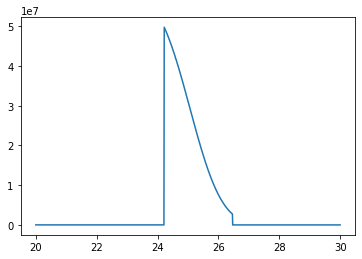

In [91]:
plt.plot(tbarDom,Lpowerval)

### Plot of Lagrangian